# Can you predict which NBA players will make the "All-Star" team?

## Part one: Clean the data

#### Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import LinearSVC
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

#### Load 'player_data.csv' 

In [2]:
df_data = pd.read_csv("player_data.csv")

#### Drop the first column

In [3]:
df_data.drop(columns=df_data.columns[0], inplace=True)

#### Remove null values from "Players" column

In [4]:
df_data.dropna(subset=["Player"], axis=0, inplace=True)

#### Replace null values with 0's in the '3P%' column

In [5]:
df_data["3P%"].fillna(value=0, inplace=True)

#### Remove rows for players who started their careers before the 1980 season

In [6]:
df_data = df_data[df_data.Year >= 1980]

#### Load in the 'all_star_appearances.pickle' file and use this data to create a column called 'all_star' that indicates whether or not a player made the All-Star team for a given year
- This file is a dictionary in which the keys are players who've made an All-Star team in their careers
- The values are all the years that the corresponding player made an All-Star team

#### Make sure this column is binary where 1 = Made All-Star team, and 0 = Did not make All-Star team

In [7]:
all_stars_dict = np.load("all_star_appearances.pickle", allow_pickle=True)
all_stars_players = np.array(list(all_stars_dict.keys()))

# to verify the data
print("total of", len(all_stars_players), "are all stars")
print("and", len(np.unique(all_stars_players)), "unique names in the dictionary (no repetition).")

# verify dataframe
print("Player column have", len(df_data.Player), "entries and ", len(df_data.Player.unique()), "unique values.")
print("(Because some players were All Star more than one time)")

total of 248 are all stars
and 248 unique names in the dictionary (no repetition).
Player column have 18927 entries and  2835 unique values.
(Because some players were All Star more than one time)


In [8]:
# Some name from Player column have an * in the end of their names
# this cell is to exclude this character
df_data.Player = df_data.Player.str.replace("*", "")

C:\Users\User\AppData\Local\Temp/ipykernel_28760/4242519868.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_data.Player = df_data.Player.str.replace("*", "")


In [9]:
# from the all star data, assign it on all_stars conlumns in player data DrataFrame.
player_year_mask = np.zeros(len(df_data))
for player, years in all_stars_dict.items():
    years = np.array(list(years))
    years = years[years >= 1980]
    for year in years:
        temp_mask = (df_data.Player == player) & (df_data.Year == year)
        if temp_mask.sum() > 1: # check if the all star data was assigned to more than one row
            print(player, year, "assigned", temp_mask.sum(), "rows")
        if temp_mask.sum() < 1: # check if the all star data was assigner to any row
            print(player, year, "have no rows assigned")
        player_year_mask += temp_mask
df_data["all_stars"] = player_year_mask

print("\nMultiple rows assignment means that the same player won more than one award at the same year")

Magic Johnson 1992 have no rows assigned
Micheal Ray Richardson 1985 have no rows assigned
Micheal Ray Richardson 1980 have no rows assigned
Micheal Ray Richardson 1981 have no rows assigned
Micheal Ray Richardson 1982 have no rows assigned
World B. Free 1980 have no rows assigned
Dominique Wilkins 1994 assigned 3 rows
Joe Barry Carroll 1987 have no rows assigned
Ricky Pierce 1991 assigned 3 rows
Dikembe Mutombo 2001 assigned 3 rows
Danny Manning 1994 assigned 3 rows
Gary Payton 2003 assigned 3 rows
Jason Kidd 2008 assigned 3 rows
Chris Gatling 1997 assigned 3 rows
Nick Van Exel 1998 have no rows assigned
Allen Iverson 2007 assigned 3 rows
Allen Iverson 2009 assigned 3 rows
Allen Iverson 2010 assigned 3 rows
Vince Carter 2005 assigned 3 rows
Ron Artest 2004 have no rows assigned
Chauncey Billups 2009 assigned 3 rows
Carmelo Anthony 2011 assigned 3 rows
Deron Williams 2011 assigned 3 rows

Multiple rows assignment means that the same player won more than one award at the same year


Above, there are the "outliers", the players that received **3 awards in a year (14 players in total)** and players that **don't have their name in the *player_data.csv* (9 players in total)**. Which means that we have **19 awards more than players** in *all_stars* column ($14*2 - 9$).

In [10]:
n_awards = 0
for years in all_stars_dict.values():
    n_awards += (np.array(list(years)) >=1980).sum()
print('The numpy indicates', n_awards, "awards")
print('total of awards (from dataframe)', df_data.all_stars.sum())
print("Difference", df_data.all_stars.sum() - n_awards, ". what matches with the calculation above.")

The numpy indicates 917 awards
total of awards (from dataframe) 936.0
Difference 19.0 . what matches with the calculation above.


## Part 2: Exploratory data analysis

#### Generate descriptive stats for the features

In [11]:
df_description = df_data.describe().T
df_description

,count,mean,std,min,25%,50%,75%,max
Year,18927.0,2000.272415,10.691977,1980.0,1992.000,2001.000,2010.000,2017.000
Age,18927.0,26.838326,3.999546,18.0,24.000,26.000,30.000,44.000
G,18927.0,49.639510,26.693379,1.0,26.000,55.000,75.000,85.000
PER,18922.0,12.395714,6.200326,-90.6,9.700,12.700,15.600,129.100
TS%,18851.0,0.503862,0.094507,0.0,0.473,0.516,0.551,1.136
ORB%,18922.0,6.153715,4.957866,0.0,2.500,5.300,9.000,100.000
DRB%,18922.0,13.741587,6.607566,0.0,8.900,12.800,18.100,100.000
TRB%,18922.0,9.948827,5.063935,0.0,6.000,9.200,13.400,100.000
AST%,18922.0,13.098023,9.569159,0.0,6.300,10.400,17.900,100.000
STL%,18922.0,1.649894,1.027371,0.0,1.100,1.500,2.100,24.200


#### Create a corr map of the features

<AxesSubplot:>

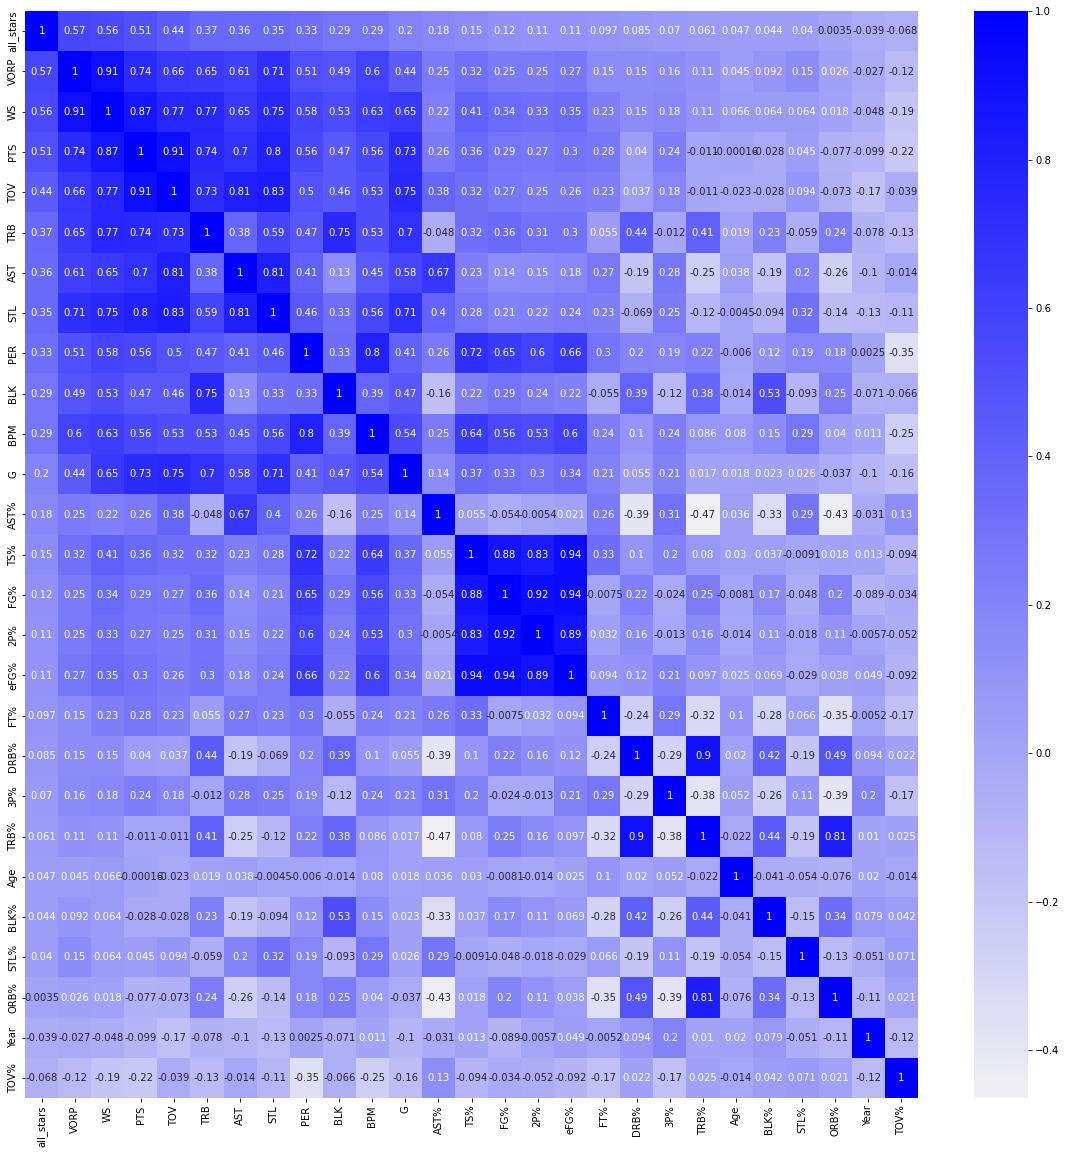

In [12]:
corr = df_data.corr()

corr.sort_values('all_stars', ascending=False, inplace=True, axis=1)
corr.sort_values('all_stars', ascending=False, inplace=True, axis=0)

f, ax = plt.subplots(figsize=(20, 20))
cmap = sns.color_palette("light:b", as_cmap=True)
sns.heatmap(corr, annot=True, cmap=cmap, ax=ax)

<AxesSubplot:title={'center':'Feature correlation with the value of interest all stars'}, xlabel='Features', ylabel='Correlation with all star'>

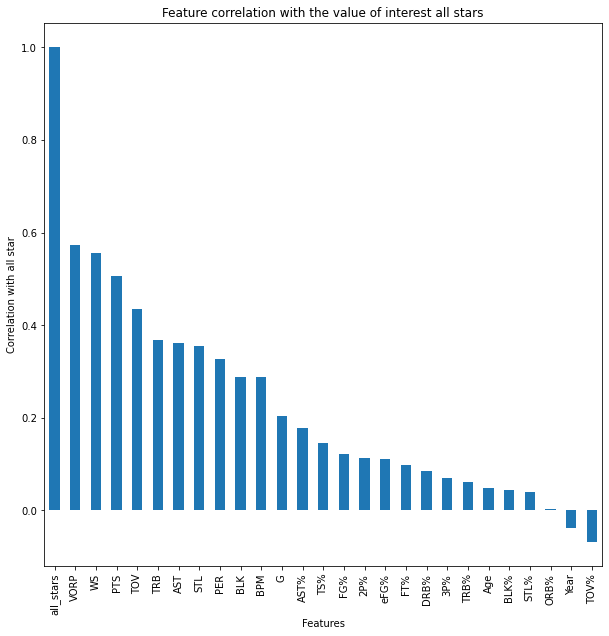

In [13]:
corr["all_stars"].plot(kind="bar", figsize=(10,10), 
                 title="Feature correlation with the value of interest all stars",
                 xlabel="Features", ylabel='Correlation with all star')

In [14]:
# low relevant features
low_relevant_features = corr["all_stars"][-5:].index.values
corr["all_stars"][-5:]

BLK%    0.043784
STL%    0.039642
ORB%    0.003472
Year   -0.038883
TOV%   -0.067931
Name: all_stars, dtype: float64

The correlation matrix shows that are high correlated features amongst themself (>80%). Thus, to use all features can be redundat and compputationally expensive.

We can, so, separate the "blocks of correlated features":

In [15]:
feature_block_1 = ['TS%', 'FG%', '2P%', 'eFG%']
feature_block_2 = ['VORP', 'WS']
feature_block_3 = ['PTS', 'TOV']
feature_block_4 = ['AST', 'STL']
feature_block_5 = ['3P%', 'TRB%']

lead_features = [
    feature_block_1[0], feature_block_2[0], feature_block_3[0], feature_block_4[0]
]
follower_features = [
    feature_block_1[1:], feature_block_2[1:], feature_block_3[1:], feature_block_4[1:]
]

lead_features = np.array(lead_features)
follower_features = np.concatenate(follower_features) 

To verify if the selected features are in fact correlated, we can plot the correlations with pair plot.

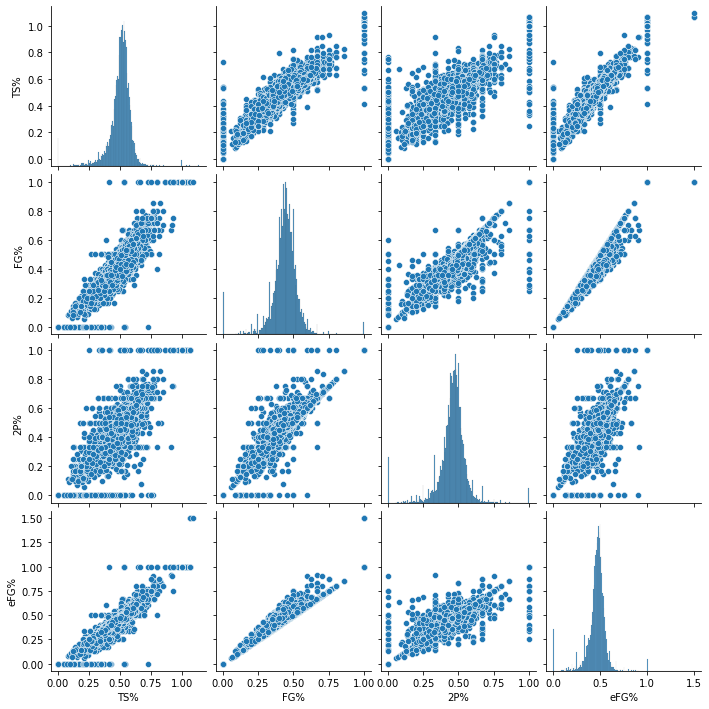

In [16]:
sns.pairplot(df_data[feature_block_1])

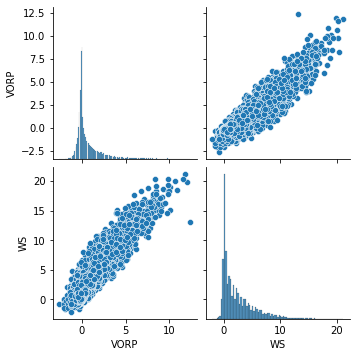

In [17]:
sns.pairplot(df_data[feature_block_2])

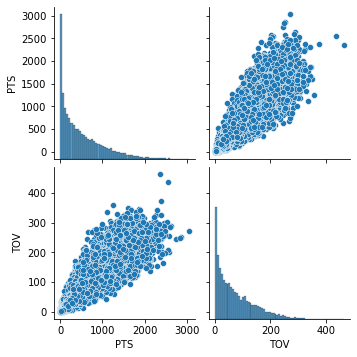

In [18]:
sns.pairplot(df_data[feature_block_3])

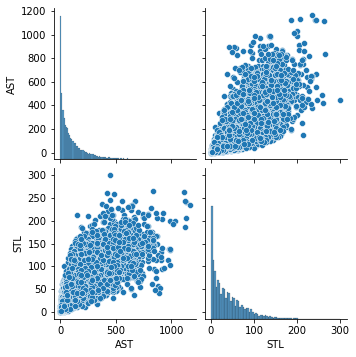

In [19]:
sns.pairplot(df_data[feature_block_4])

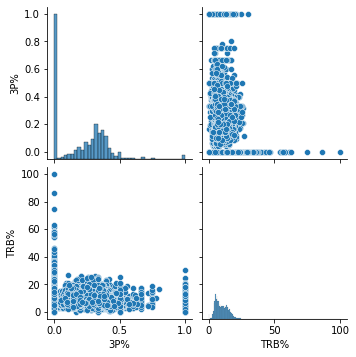

In [20]:
sns.pairplot(df_data[feature_block_5]) # seems not correlated at all. Outliers can lead to error

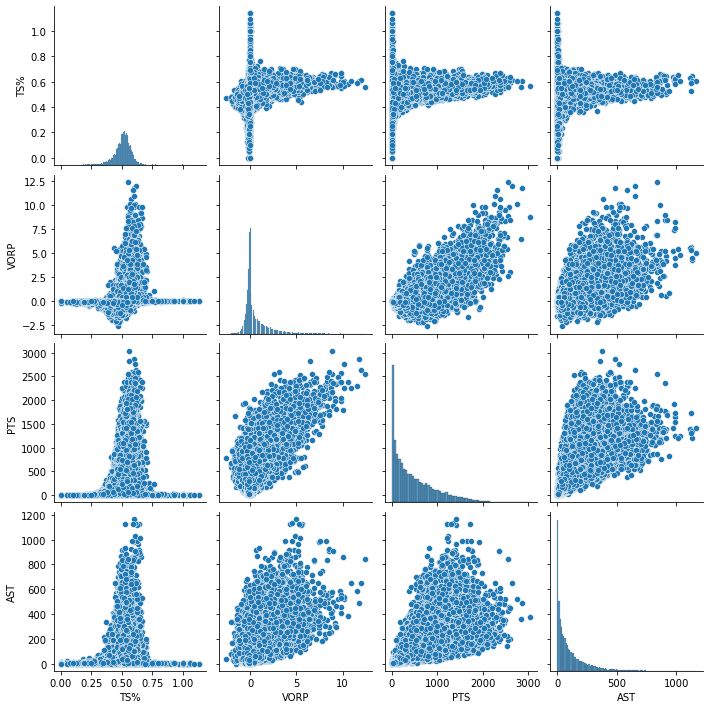

In [21]:
sns.pairplot(df_data[lead_features])

The last pair plot shows the most correlated to *all_stars* feature, and they have indeed low correlation amonsgst themself. 

#### Graph the distibution of the 'Age' feature

<AxesSubplot:ylabel='Frequency'>

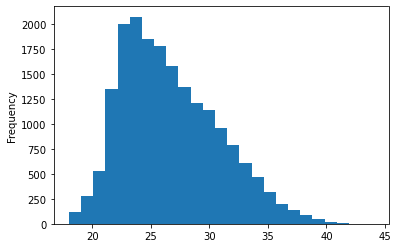

In [22]:
df_data.Age.plot(kind='hist', bins=25)

## Part 3: Classification

### Build a classifier that predicts whether or not a player makes an All-Star team based on their stats for that season

Now we start the get the relevant features to train our machine learning model.

In [23]:
# crating the data to be used on the machine learning model
df_train = df_data.copy()
df_train.drop(follower_features, axis=1, inplace=True) # remove redundant features
df_train.drop(low_relevant_features, axis=1, inplace=True) # remove low relevant features

total_features = df_train.columns.values[:-1] # removing the all_star comlumn

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean') # for missing values
le_player = LabelEncoder()
le_pos = LabelEncoder()
le_tm = LabelEncoder()

# categorical features trnafomation in numerical values
df_train['Player'] = le_player.fit_transform(df_train['Player'])
df_train['Pos'] = le_pos.fit_transform(df_train['Pos'])
df_train['Tm'] = le_tm.fit_transform(df_train['Tm'])

# imputing mean value for the missing cells
num_features = df_train.drop(['Player', 'Pos', 'Tm', 'all_stars'], axis=1).columns
df_train[num_features] = imp_mean.fit_transform(df_train[num_features])

df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18927 entries, 5727 to 24690
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Player     18927 non-null  int32  
 1   Pos        18927 non-null  int32  
 2   Age        18927 non-null  float64
 3   Tm         18927 non-null  int32  
 4   G          18927 non-null  float64
 5   PER        18927 non-null  float64
 6   TS%        18927 non-null  float64
 7   DRB%       18927 non-null  float64
 8   TRB%       18927 non-null  float64
 9   AST%       18927 non-null  float64
 10  BPM        18927 non-null  float64
 11  VORP       18927 non-null  float64
 12  3P%        18927 non-null  float64
 13  FT%        18927 non-null  float64
 14  TRB        18927 non-null  float64
 15  AST        18927 non-null  float64
 16  BLK        18927 non-null  float64
 17  PTS        18927 non-null  float64
 18  all_stars  18927 non-null  float64
dtypes: float64(16), int32(3)
memory usage: 2.7 

**Linear SVC** is the algotihm chosen. It demands more computational effort than their counterparts, but less parameters tunnings (in short, less complicated). It is suitable for the low dimensional small dataset provided.

In [24]:
list_mse, list_hit = list(), list()
scaler = StandardScaler()

X = scaler.fit_transform(df_train[total_features])
y = df_train['all_stars']

for i in range(50):
    X_train, X_test, y_train, y_test = train_test_split( 
            X, y, test_size=0.25)

    model = LinearSVC(tol=1e-5, max_iter=100000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred) # for all stars and non-allstars players
    hit_precentage = ((y_test + y_pred) == 2).sum()/(y_pred == 1).sum()*100
    
    print('Run', i, 'MSE test:', mse, '/ Hit percentage:', hit_precentage, "%")
    
    list_mse.append(mse)
    list_hit.append(hit_precentage)

print('Mean MSE:', np.mean(list_mse), 'Mean Hit percentage:', np.mean(list_hit), "%")

Run 0 MSE test: 0.029163144547759933 / Hit percentage: 80.0 %
Run 1 MSE test: 0.03021978021978022 / Hit percentage: 79.28994082840237 %
Run 2 MSE test: 0.030008453085376162 / Hit percentage: 76.11111111111111 %
Run 3 MSE test: 0.0283178360101437 / Hit percentage: 80.11695906432749 %
Run 4 MSE test: 0.026415891800507185 / Hit percentage: 83.33333333333334 %
Run 5 MSE test: 0.03127641589180051 / Hit percentage: 80.66666666666666 %
Run 6 MSE test: 0.02852916314454776 / Hit percentage: 76.28205128205127 %
Run 7 MSE test: 0.030008453085376162 / Hit percentage: 74.53416149068323 %
Run 8 MSE test: 0.029163144547759933 / Hit percentage: 76.28205128205127 %
Run 9 MSE test: 0.026204564666103127 / Hit percentage: 79.65116279069767 %
Run 10 MSE test: 0.0283178360101437 / Hit percentage: 75.72254335260115 %
Run 11 MSE test: 0.029797125950972104 / Hit percentage: 80.74534161490683 %
Run 12 MSE test: 0.0253592561284869 / Hit percentage: 86.42857142857143 %
Run 13 MSE test: 0.032121724429416736 / Hit 

The built model can **predict with arround 97% of accuracy** if a player will **be or not** the All Star team. And have around **78% chance to predict if the player is all star correctly**.

For the presented amount of data, this model works well. More efficient models, features and model's parameters selection, and other dimension reduction strategies would be necessary for a larger data base (in number of samples and/or features). For the present case, the computational time is reasonable and the model seems to work well.

To exemplify our model, let's pretend that we are in 2016 and we know as data from each player except if they joined the all star team or not, and we want to predict it.
So, the trainning data is everything **UNTIL 2016**, and the test data is everything **IN 2016**.

In [25]:
# tranning with the data until 2016
df_history = df_train[df_data.Year < 2016] # base for training 
df_2016 = df_train[df_data.Year == 2016] # to predict all star

X_train = scaler.fit_transform(df_history[total_features])
y_train = df_history["all_stars"]
X_test = scaler.fit_transform(df_2016[total_features])
y_test = df_2016["all_stars"]

model = LinearSVC(tol=1e-5, max_iter=100000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

hit_precentage = ((y_test + y_pred) == 2).sum()/(y_pred == 1).sum()*100

mse = mean_squared_error(y_test, y_pred)
print('MSE:', mse, '/ Hit percentage:', hit_precentage, '%')

df_2016['all_stars_pred'] = y_pred

MSE: 0.01903114186851211 / Hit percentage: 80.0 %


C:\Users\User\AppData\Local\Temp/ipykernel_28760/395129265.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2016['all_stars_pred'] = y_pred


So, **80% of the players** were correcly predicted as all stars for the year 2016. The following cells are the names for the predicti player by the model and the actual players who were in fact in the all star team.

In [26]:
# Players predicted for 2016 from <2016 data
np.sort(le_player.inverse_transform(df_2016[df_2016['all_stars_pred'] == 1].Player.values))

array(['Al Horford', 'Anthony Davis', 'Brook Lopez', 'Carmelo Anthony',
       'Chris Paul', 'Damian Lillard', 'DeMar DeRozan',
       'DeMarcus Cousins', 'Draymond Green', 'Hassan Whiteside',
       'Isaiah Thomas', 'James Harden', 'Jimmy Butler', 'John Wall',
       'Karl-Anthony Towns', 'Kawhi Leonard', 'Kemba Walker',
       'Kevin Durant', 'Kyle Lowry', 'LeBron James', 'Pau Gasol',
       'Paul George', 'Paul Millsap', 'Russell Westbrook',
       'Stephen Curry'], dtype=object)

In [27]:
# Players actually selected for the 2016 All Star
np.sort(le_player.inverse_transform(df_2016[df_2016['all_stars'] == 1].Player.values))

array(['Al Horford', 'Andre Drummond', 'Anthony Davis', 'Carmelo Anthony',
       'Chris Bosh', 'Chris Paul', 'DeMar DeRozan', 'DeMarcus Cousins',
       'Draymond Green', 'Dwyane Wade', 'Isaiah Thomas', 'James Harden',
       'Jimmy Butler', 'John Wall', 'Kawhi Leonard', 'Kevin Durant',
       'Klay Thompson', 'Kobe Bryant', 'Kyle Lowry', 'LaMarcus Aldridge',
       'LeBron James', 'Pau Gasol', 'Paul George', 'Paul Millsap',
       'Russell Westbrook', 'Stephen Curry'], dtype=object)